In [2]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 1
    eval_batch_size = 2  # how many images to sample during evaluation
    num_epochs = 1
    gradient_accumulation_steps = 1
    learning_rate = 1e-5
    lr_warmup_steps = 2000
    save_image_epochs = 10
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-music-256"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = False  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [3]:
from datasets import load_dataset, Dataset
from datasets import Image
import os


# Path to your local image folder
image_folder = "music/images"

# Load images into Hugging Face dataset format
dataset = load_dataset("imagefolder", data_dir=image_folder, split="train")

# Cast to Image feature
dataset = dataset.cast_column("image", Image())

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

C:\Users\mharu\AppData\Local\Temp\ipykernel_8028\3278871621.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


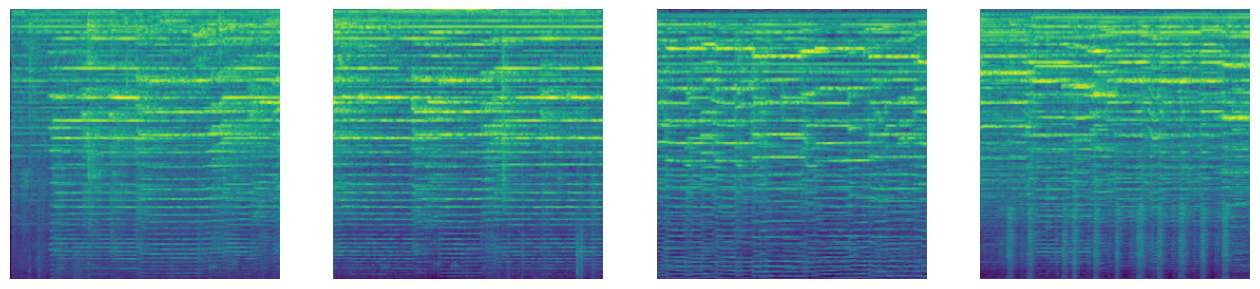

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        #transforms.Resize((config.image_size, config.image_size)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.5], [0.5]),
    ]
)

In [7]:
def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [8]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Create a UNet2DModel

Pretrained models in 🧨 Diffusers are easily created from their model class with the parameters you want. For example, to create a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel):

In [10]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

It is often a good idea to quickly check the sample image shape matches the model output shape:

In [11]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 256, 256])


In [12]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 256, 256])


Great! Next, you'll need a scheduler to add some noise to the image.

## Create a scheduler

The scheduler behaves differently depending on whether you're using the model for training or inference. During inference, the scheduler generates image from the noise. During training, the scheduler takes a model output - or a sample - from a specific point in the diffusion process and applies noise to the image according to a *noise schedule* and an *update rule*.

Let's take a look at the [DDPMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler) and use the `add_noise` method to add some random noise to the `sample_image` from before:

In [13]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [14]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Train the model

By now, you have most of the pieces to start training the model and all that's left is putting everything together.

First, you'll need an optimizer and a learning rate scheduler:

In [15]:
import torch
from diffusers import UNet2DModel, DDPMScheduler


# 2) load the .bin checkpoint
state_dict = torch.load("ddpm-music-256/unet/diffusion_pytorch_model.79.bin")

# 3) inject weights
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# scheduler as before
noise_scheduler = DDPMScheduler.from_config("ddpm-music-256/scheduler/scheduler_config.json")

c:\Users\mharu\miniconda3\envs\aud2\Lib\site-packages\diffusers\configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [16]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Then, you'll need a way to evaluate the model. For evaluation, you can use the [DDPMPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/ddpm#diffusers.DDPMPipeline) to generate a batch of sample images and save it as a grid:

In [17]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    output_dir  = Path("generated")

    # Make sure output directory exists
    output_dir.mkdir(parents=True, exist_ok=True)

    # Find existing sample files and determine next index
    existing = list(output_dir.glob("sample_*.png"))
    if existing:
        # extract the numeric part from filenames like "sample_005.png"
        existing_idxs = [
            int(p.stem.split("_")[1])
            for p in existing
            if p.stem.split("_")[1].isdigit()
        ]
        next_idx = max(existing_idxs) + 1
    else:
        next_idx = 0

    for i, img in enumerate(images):
      idx = next_idx + i
      filename = output_dir / f"sample_{idx:03d}.png"
      img.save(filename)

    # # Make a grid out of the images
    # image_grid = make_grid(images, rows=4, cols=4)

    # # Save the images
    # test_dir = os.path.join(config.output_dir, "samples")
    # os.makedirs(test_dir, exist_ok=True)
    # image_grid.save(f"{test_dir}/{epoch:04d}.png")

Now you can wrap all these components together in a training loop with 🤗 Accelerate for easy TensorBoard logging, gradient accumulation, and mixed precision training. To upload the model to the Hub, write a function to get your repository name and information and then push it to the Hub.

<Tip>

💡 The training loop below may look intimidating and long, but it'll be worth it later when you launch your training in just one line of code! If you can't wait and want to start generating images, feel free to copy and run the code below. You can always come back and examine the training loop more closely later, like when you're waiting for your model to finish training. 🤗

</Tip>

In [19]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os



def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        # for step, batch in enumerate(train_dataloader):
        #     clean_images = batch["images"]
        #     # Sample noise to add to the images
        #     noise = torch.randn(clean_images.shape).to(clean_images.device)
        #     bs = clean_images.shape[0]

        #     # Sample a random timestep for each image
        #     timesteps = torch.randint(
        #         0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        #     ).long()

        #     # Add noise to the clean images according to the noise magnitude at each timestep
        #     # (this is the forward diffusion process)
        #     noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        #     with accelerator.accumulate(model):
        #         # Predict the noise residual
        #         noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        #         loss = F.mse_loss(noise_pred, noise)

        #         torch.cuda.synchronize()
        #         accelerator.backward(loss)
        #         torch.cuda.synchronize()

        #         accelerator.clip_grad_norm_(model.parameters(), 1.0)
        #         optimizer.step()
        #         lr_scheduler.step()
        #         optimizer.zero_grad()
            
            
        #     progress_bar.update(1)
        #     logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        #     progress_bar.set_postfix(**logs)
        #     accelerator.log(logs, step=global_step)
        #     global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            evaluate(config, epoch, pipeline)

            #if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            #pipeline.save_pretrained(config.output_dir, safe_serialization=False, variant=str(epoch))
                

Phew, that was quite a bit of code! But you're finally ready to launch the training with 🤗 Accelerate's [notebook_launcher](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher) function. Pass the function the training loop, all the training arguments, and the number of processes (you can change this value to the number of GPUs available to you) to use for training:

In [20]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  3%|▎         | 28/1000 [00:05<03:07,  5.18it/s]


KeyboardInterrupt: 